In [1]:
# Jupyter magic
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # standard Python plotting library
from scipy.signal import find_peaks, peak_prominences, peak_widths
# import the tdt library
import tdt
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc
import scipy.stats as stats

In [2]:
blockpath = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\EN174_RI30D3-240720-144035" 
data = tdt.read_block(blockpath) # created a dictionary to read
isosbestic = '_415A'
dopa = '_465A'
RNP = 'RNP_'
RMG = 'RMG_'
URM = 'URM_'
STREAM_STORE = '_465A'   #seems to be having trouble finding this later on?
ARTIFACT     = np.inf       # optionally set an artifact rejection level (figure out what this actually does)
CHANNEL      = 1
TRANGE       = [-5, 10]  # window size [start time relative to epoc onset, window duration]
BASELINE_PER = [-5, 2]

read from t=0s to t=1799.09s


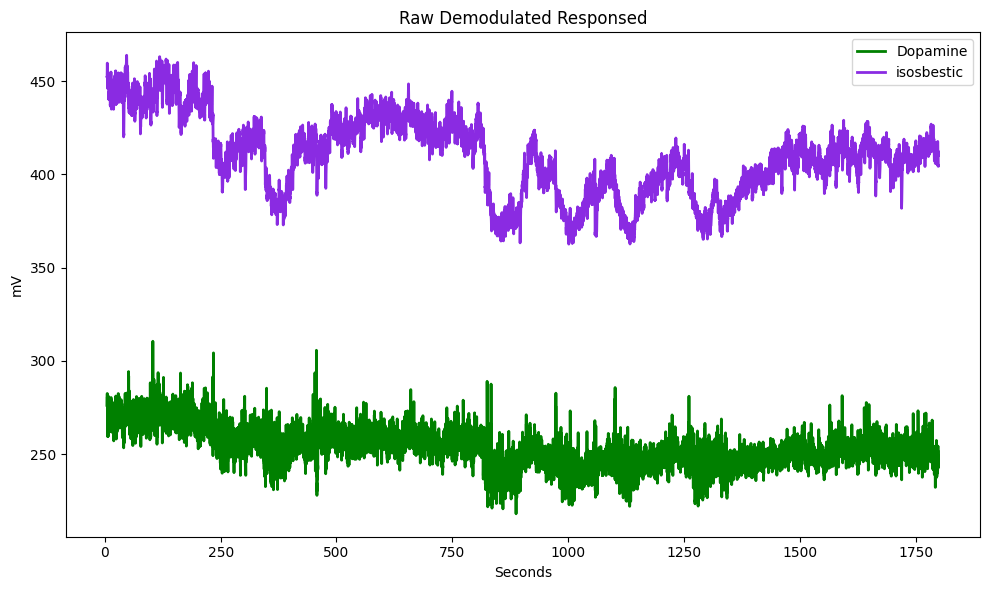

In [3]:
# Make a time array based on the number of samples and sample freq of 
# the demodulated streams
time = np.linspace(1,len(data.streams[dopa].data), len(data.streams[dopa].data))/data.streams[dopa].fs
t = 5
inds = np.where(time>t)
ind = inds[0][0]
time = time[ind:] # go from ind to final index
data.streams[dopa].data = data.streams[dopa].data[ind:]
data.streams[isosbestic].data = data.streams[isosbestic].data[ind:]

# Plot both unprocessed demodulated stream            
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces
p1, = ax0.plot(time, data.streams[dopa].data, linewidth=2, color='green', label='Dopamine')
p2, = ax0.plot(time, data.streams[isosbestic].data, linewidth=2, color='blueviolet', label='isosbestic')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responsed')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

# Jupyter for some reason (sometimes) shows the figure without be called, 
# Likely when plt.figure() is called
# otherwise you would call fig in a line by itself like:
# fig


In [4]:
def readFile(blockpath):
    data = tdt.read_block(blockpath)
    time = np.linspace(1,len(data.streams[dopa].data), len(data.streams[dopa].data))/data.streams[dopa].fs
    t = 5
    inds = np.where(time>t)
    ind = inds[0][0]
    time = time[ind:] # go from ind to final index
    data.streams[dopa].data = data.streams[dopa].data[ind:]
    data.streams[isosbestic].data = data.streams[isosbestic].data[ind:]
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []

    for i in range(0, len(data.streams[dopa].data), N):
        F465.append(np.mean(data.streams[dopa].data[i:i+N-1])) # This is the moving window mean
    data.streams[dopa].data = F465

    for i in range(0, len(data.streams[isosbestic].data), N):
        F415.append(np.mean(data.streams[isosbestic].data[i:i+N-1]))
    data.streams[isosbestic].data = F415

    #decimate time array to match length of demodulated stream
    time = time[::N] # go from beginning to end of array in steps on N
    time = time[:len(data.streams[dopa].data)]

    x = np.array(data.streams[isosbestic].data)
    y = np.array(data.streams[dopa].data)
    bls = np.polyfit(x, y, 1)
    Y_fit_all = np.multiply(bls[0], x) + bls[1]
    Y_dF_all = y - Y_fit_all

    dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
    return data, dFF

In [5]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F415 = []
F465 = []

for i in range(0, len(data.streams[dopa].data), N):
    F465.append(np.mean(data.streams[dopa].data[i:i+N-1])) # This is the moving window mean
data.streams[dopa].data = F465

for i in range(0, len(data.streams[isosbestic].data), N):
    F415.append(np.mean(data.streams[isosbestic].data[i:i+N-1]))
data.streams[isosbestic].data = F415

#decimate time array to match length of demodulated stream
time = time[::N] # go from beginning to end of array in steps on N
time = time[:len(data.streams[dopa].data)]

# Detrending and dFF
# Full trace dFF according to Lerner et al. 2015
# https://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline

x = np.array(data.streams[isosbestic].data)
y = np.array(data.streams[dopa].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)


In [45]:
def CreateBouts(path):
    n = 3 # how many consecutive pokes is a bout
    bout_freq = n-1
    BOUT_TIME_THRESHOLD = 5
    UnNP_diff_indices_offset= []
    data, dFF = readFile(path)
    UnNP_diff = np.diff(data.epocs.UnNP.onset)
    UnNP_diff_indices = np.where(UnNP_diff >= BOUT_TIME_THRESHOLD)[0]
    
    for i in range(len(UnNP_diff_indices)):
        try:
            UnNP_diff_indices_offset.append(UnNP_diff_indices[i+1]-1)
        except IndexError:
            UnNP_diff_indices_offset.append(len(UnNP_diff)-1)
            continue

    bout_indx = np.where((UnNP_diff_indices_offset - UnNP_diff_indices) >= bout_freq)[0]
    UnNP_diff_indices=np.array(UnNP_diff_indices)
    UnNP_diff_indices_offset = np.array(UnNP_diff_indices_offset)
    onset_indx = UnNP_diff_indices[bout_indx]
    offset_indx = UnNP_diff_indices_offset[bout_indx]
    onset_frames = np.array(data.epocs.UnNP.onset[onset_indx]*101.8, dtype=int)
    offset_frames = np.array(data.epocs.UnNP.onset[offset_indx]*101.8, dtype=int)

    aucsPerTime = []
    aucs = []
    for on, off in zip(onset_frames, offset_frames):
        end = off+102
        aucsPerTime.append(auc(range(end-on), dFF[on:end])/((end-on)/101.8)) #first UnNp to last UnNP in bout + 1 second
        aucs.append(auc(range(end-on), dFF[on:end]))

    diff_arr = []
    for on,off in zip(onset_indx, offset_indx):
        diff_arr.append((off-on)+1)
    aucPerEpoc = []
    for i in range(len(aucsPerTime)):
        aucPerEpoc.append(aucs[i]/diff_arr[i])

    return aucsPerTime, aucPerEpoc, diff_arr

In [8]:
rnp_on = data.epocs.RNP_.onset
rmg_on = data.epocs.RMG_.onset
unp_on = data.epocs.UnNP.onset
unp_bins= {}

In [9]:
binned_df = pd.DataFrame()

In [10]:
vals = []
for i in range(len(rnp_on)): # each block represents time between rewarded magazine and the subsequent rewarded nose poke
    bin_values = []
    for j in range(len(unp_on)):
        if ( unp_on[j] < rmg_on[len(rmg_on)-1]): # addresses boundary of last rewarded mag entry
            if (i == 0) and (unp_on[j] < rnp_on[i]): # time before first rnp since no rmg
                bin_values.append(unp_on[j])
                binned_df.loc[j,'block'] = i
                binned_df.loc[j,'Unrewarded_NP'] = unp_on[j]
            elif (unp_on[j] < rnp_on[i]) and (unp_on[j] > rmg_on[i-1]):
                bin_values.append(unp_on[j]-rmg_on[i-1])
                binned_df.loc[j,'block'] = i
                binned_df.loc[j,'Unrewarded_NP'] = (unp_on[j]-rmg_on[i-1])   
    if i==0:
        vals.append(rnp_on[i])
    else:
        vals.append(rnp_on[i]-rmg_on[i-1])

In [11]:
bins = {'bin': unp_bins}

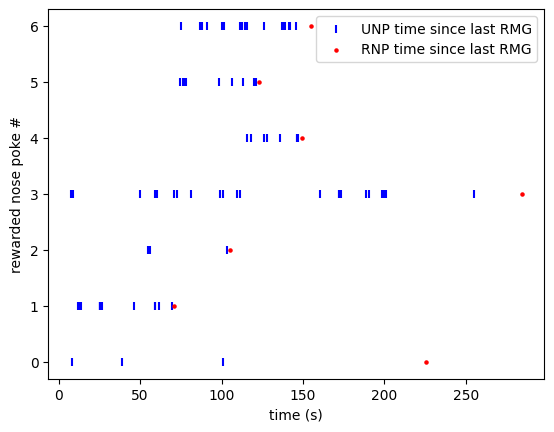

In [12]:
fig, ax = plt.subplots(1,1)
p1 = ax.scatter(x = binned_df['Unrewarded_NP'], y = binned_df["block"], color = 'blue', label = 'UNP time since last RMG', marker = '|')
p2 = ax.scatter(y = np.arange(len(vals)), x = vals, color = 'r', label = 'RNP time since last RMG', marker = 'o', s = 5)
plt.xlabel("time (s)")
plt.ylabel('rewarded nose poke #')
ax.legend(handles = [p1,p2], loc = 'upper right')

In [13]:
peaks = find_peaks(dFF, prominence=5)
peak_dff = []
for i in peaks[0]:
    peak_dff.append(dFF[i])

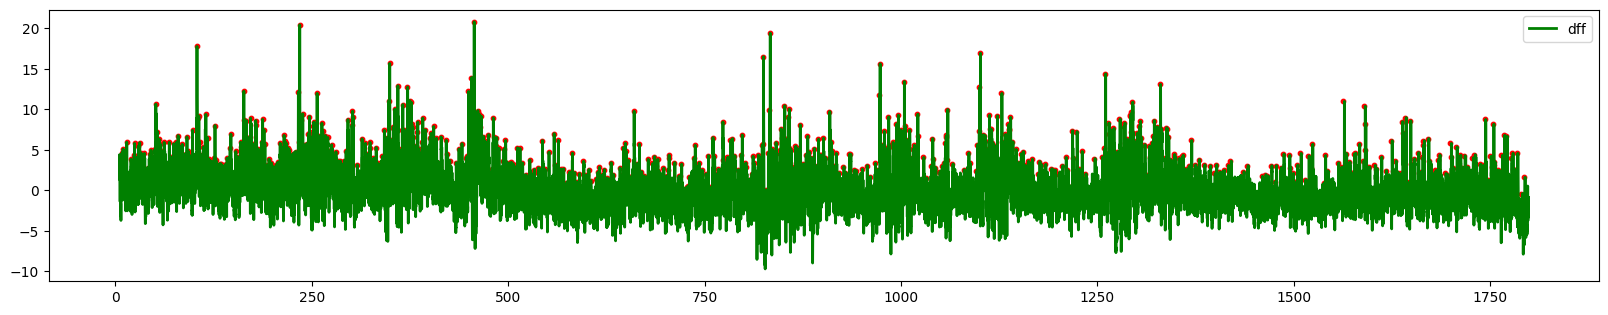

In [14]:
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)
ax2.scatter(x= peaks[0]/(101.8)+5, y =peak_dff, s = 10, color = 'red' )
p1, = ax2.plot(time, dFF, linewidth=2, color='green', label='dff')
ax2.legend(handles=[p1], loc='upper right')

In [15]:
(peaks[0]/101.8)+5

array([   7.85854617,    8.38899804,    9.7151277 ,   14.35166994,
         19.78388998,   21.47347741,   22.77996071,   23.70333988,
         24.19449902,   27.25933202,   29.04715128,   30.81532417,
         32.64243615,   36.79764244,   41.00196464,   43.93909627,
         45.2848723 ,   47.36738703,   50.19646365,   51.31630648,
         53.33005894,   55.80550098,   57.22986248,   59.29273084,
         61.90569745,   67.043222  ,   68.44793713,   70.91355599,
         73.89980354,   76.06090373,   77.39685658,   77.96660118,
         79.65618861,   82.74066798,   85.        ,   86.74852652,
         89.32220039,   90.95284872,   92.54420432,   96.62082515,
         98.10412574,  103.67387033,  105.2259332 ,  106.04125737,
        106.95481336,  108.49705305,  111.69941061,  114.97053045,
        117.21021611,  118.48722986,  122.77013752,  125.64833006,
        126.5913556 ,  127.65225933,  132.45579568,  134.10609037,
        135.64833006,  137.92730845,  140.59921415,  142.01375

In [16]:
t = int(4*101.8) # seconds * sampling values
dff_peaks = []
for i in peaks[0]:
    if (i-t > 0):
        dff_peaks.append(dFF[i-t:i+t])
    else:
        dff_peaks.append(dFF[0:i+t])

In [17]:
normalizedPeakFreq = len(peaks[0])/len(data.epocs.RNP_.onset)
normalizedPeakFreq

108.0

In [18]:
test_arr = []
for i in data.epocs.RMG_.onset:
    arr = [int((i-5)*101.8), int((i+5)*101.8)]
    test_arr.append(arr)

other_arr = []
for i in data.epocs.RNP_.onset:
    arr = [int((i-5)*101.8), int((i+5)*101.8)]
    other_arr.append(arr)

In [19]:
other_arr

[[22434, 23452],
 [33866, 34884],
 [45117, 46135],
 [82027, 83045],
 [97892, 98910],
 [111066, 112084],
 [127264, 128282]]

In [20]:
test_arr

[[26634, 27652],
 [34384, 35402],
 [53089, 54107],
 [82663, 83681],
 [98516, 99534],
 [111478, 112496],
 [154682, 155700]]

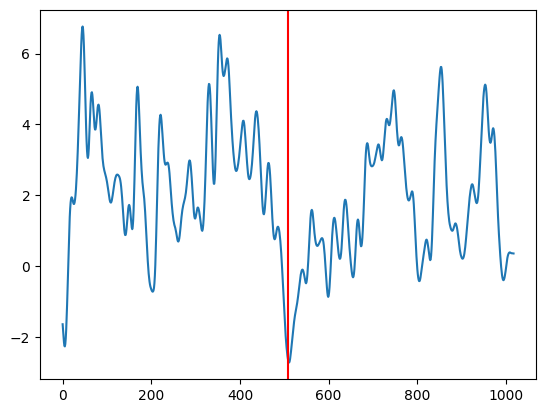

In [21]:
ax5 = sns.lineplot(dFF[test_arr[0][0]:test_arr[0][1]])
# sns.lineplot(dFF[other_arr[0][0]:other_arr[0][1]], color = 'green')
ax5.axvline(x = (test_arr[0][1]-test_arr[0][0])/2, color = 'red')
# ax5.axvline(x = test_arr[0][1] -other_arr[0][0], color = 'gray')

In [22]:
UnNP_diff = np.diff(data.epocs.UnNP.onset)
BOUT_TIME_THRESHOLD = 5
UnNP_diff_indices = np.where(UnNP_diff >= BOUT_TIME_THRESHOLD)[0]

In [23]:
UnNP_diff_indices_offset= []
for i in range(len(UnNP_diff_indices)):
    try:
        UnNP_diff_indices_offset.append(UnNP_diff_indices[i+1]-1)
    except IndexError:
        UnNP_diff_indices_offset.append(len(UnNP_diff)-1)
        continue

n = 3 # how many consecutive pokes is a bout
bout_freq = n-1
bout_indx = np.where((UnNP_diff_indices_offset - UnNP_diff_indices) >= bout_freq)[0]
UnNP_diff_indices=np.array(UnNP_diff_indices)
UnNP_diff_indices_offset = np.array(UnNP_diff_indices_offset)

print((UnNP_diff_indices))
print((UnNP_diff_indices_offset))


[  0   1   2   4   7  12  13  16  17  19  20  21  23  24  26  28  29  31
  33  34  37  39  42  43  44  46  48  49  52  53  57  58  59  60  63  64
  68  70  74  75  82  83  84  85  87  88  90  91  92  96 100 103 105 106]
[  0   1   3   6  11  12  15  16  18  19  20  22  23  25  27  28  30  32
  33  36  38  41  42  43  45  47  48  51  52  56  57  58  59  62  63  67
  69  73  74  81  82  83  84  86  87  89  90  91  95  99 102 104 105 106]


In [24]:
print(len(UnNP_diff_indices), len(UnNP_diff_indices_offset))
print(bout_indx)

54 54
[ 3  4  6 19 21 27 29 33 35 37 39 48 49 50]


In [25]:
print(UnNP_diff_indices[bout_indx], UnNP_diff_indices_offset[bout_indx])

[  4   7  13  34  39  49  53  60  64  70  75  92  96 100] [  6  11  15  36  41  51  56  62  67  73  81  95  99 102]


In [26]:
onset_indx = UnNP_diff_indices[bout_indx]
offset_indx = UnNP_diff_indices_offset[bout_indx]

In [27]:
onset_frames = np.array(data.epocs.UnNP.onset[onset_indx]*101.8, dtype=int)
offset_frames = np.array(data.epocs.UnNP.onset[offset_indx]*101.8, dtype=int)

In [28]:
print(onset_frames)
print(offset_frames)

[ 23117  28524  31852  69904  72967  96990  98656 110532 119630 122327
 124832 152756 154572 156323]
[ 28398  29754  33155  71123  73942  98080 106951 111354 120940 123620
 126448 154401 156124 157989]


<Axes: >

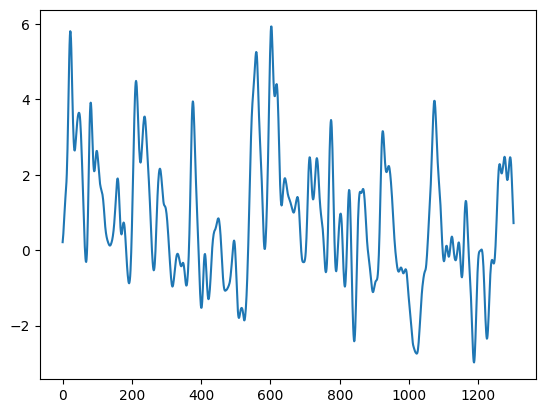

In [29]:
sns.lineplot(dFF[onset_frames[2]:offset_frames[2]])

In [30]:
print(onset_indx, offset_indx)

[  4   7  13  34  39  49  53  60  64  70  75  92  96 100] [  6  11  15  36  41  51  56  62  67  73  81  95  99 102]


In [31]:
aucsPerTime = []
for on, off in zip(onset_frames, offset_frames):
    aucsPerTime.append(auc(range(off-on), dFF[on:off])/(off-on))


In [32]:
diff_arr = []
for on,off in zip(onset_indx, offset_indx):
    diff_arr.append((off-on)+1)
aucPerEpoc = []
for i in range(len(aucsPerTime)):
    aucPerEpoc.append(aucsPerTime[i]/diff_arr[i])

In [33]:
aucsPerTime
print(aucPerEpoc)

[0.5272092400235102, 0.13883301817577304, 0.2663940592093515, -0.3769802469546258, -0.6597652803501513, -0.4138616350086389, -0.02998084715697207, -0.22125366155967563, -0.1740397819183911, -0.16459293107202166, -0.12063954290500024, -0.29639490029808574, -0.35808090499338824, -0.2877496640945525]


In [53]:
wtpath = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\EN171_RI30D3-240719-151328"
wauctime, waucepoc, wepocs = CreateBouts(wtpath)
hauctime,haucepoc, hepocs = CreateBouts(blockpath)

read from t=0s to t=1799.21s


C:\Users\User\AppData\Local\Temp\ipykernel_19344\3906748338.py:28: RankWarning: Polyfit may be poorly conditioned
  bls = np.polyfit(x, y, 1)


read from t=0s to t=1799.09s


In [55]:
print((np.min(waucepoc)), (np.min(haucepoc)))
print((np.min(hauctime)), (np.min(wauctime)))

-7569.945424321883 -666.1775284331912
-188.90493703203026 -273.43126346397435


In [56]:
hdf = pd.DataFrame()
wdf = pd.DataFrame()
for i in range(len(wauctime)):
    wdf.loc[i, 'genotype'] = 'wt'
    wdf.loc[i, 'auc per time']= wauctime[i]
    wdf.loc[i, 'auc per epoc'] = waucepoc[i]
    if i <= 4:
        wdf. loc[i, 'first 5 bouts: auc per epoc'] = waucepoc[i]
        wdf. loc[i, 'first 5 bouts: auc per time'] = wauctime[i]
    elif i >= (len(wauctime)-5):
        wdf. loc[i, 'last 5 bouts: auc per epoc'] = waucepoc[i]
        wdf. loc[i, 'last 5 bouts: auc per time'] = wauctime[i]
for i in range(len(hauctime)):
    hdf.loc[i, 'genotype'] = 'het'
    hdf.loc[i, 'auc per time']= hauctime[i]
    hdf.loc[i, 'auc per epoc'] = haucepoc[i]
    if i <= 4:
        hdf.loc[i, 'first 5 bouts: auc per epoc'] = haucepoc[i]
        hdf.loc[i, 'first 5 bouts: auc per time'] = hauctime[i]
    elif i >= (len(hauctime)-5):
        hdf.loc[i, 'last 5 bouts: auc per epoc'] = haucepoc[i]
        hdf.loc[i, 'last 5 bouts: auc per time'] = hauctime[i]
df = hdf._append(wdf, ignore_index = True)

MannwhitneyuResult(statistic=124.0, pvalue=0.4194324996066613)
MannwhitneyuResult(statistic=113.0, pvalue=0.7434206976952524)


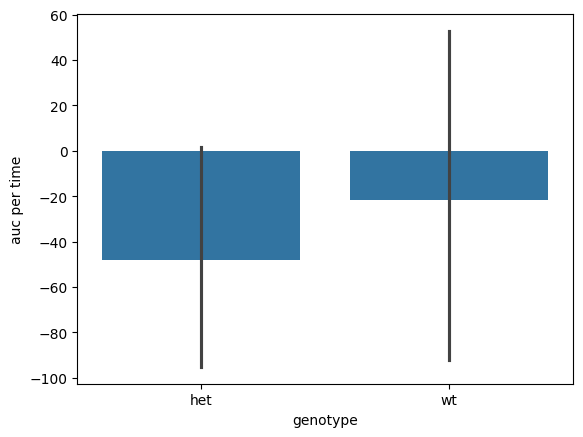

In [58]:
sns.barplot(df, x = 'genotype', y= 'auc per time')
print(stats.mannwhitneyu(wauctime,hauctime))
print(stats.mannwhitneyu(waucepoc,haucepoc))

MannwhitneyuResult(statistic=22.0, pvalue=0.05555555555555555)


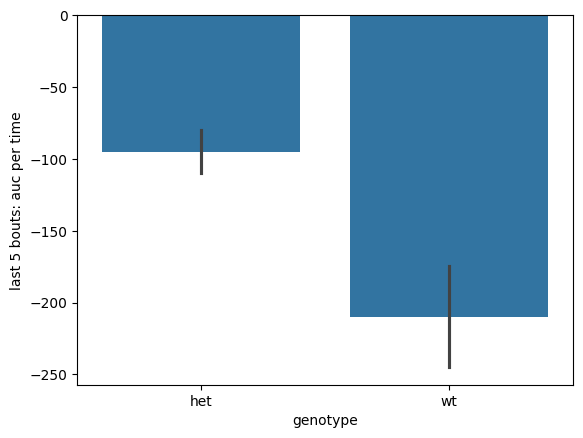

In [59]:
sns.barplot(df, x='genotype', y = 'last 5 bouts: auc per time', errorbar='se')
print(stats.mannwhitneyu(hdf['last 5 bouts: auc per time'].dropna(), wdf['last 5 bouts: auc per time'].dropna()))

MannwhitneyuResult(statistic=25.0, pvalue=0.007936507936507936)
1599.8184242569996 -2943.9621258120706


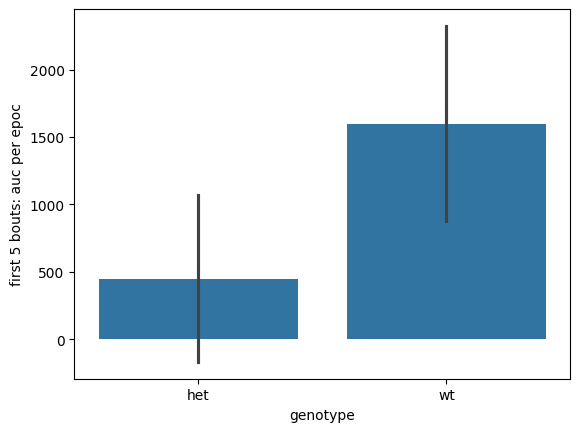

In [60]:
sns.barplot(df, x='genotype', y = 'first 5 bouts: auc per epoc', errorbar='se')
print(stats.mannwhitneyu(wdf['first 5 bouts: auc per epoc'].dropna(), wdf['last 5 bouts: auc per epoc'].dropna()))
print(np.mean(wdf['first 5 bouts: auc per epoc'].dropna()), np.mean(wdf['last 5 bouts: auc per epoc'].dropna()))

In [52]:
hetTanks = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\HET/*"
wtTanks = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\WT/*"

import glob
het_all_time = []
het_all_epoc = []
wt_all_time = []
wt_all_epoc = []
for file in glob.glob(hetTanks):
    timed, perepoc, hepocs = CreateBouts(file)
    het_all_time.extend(timed)
    het_all_epoc.extend(perepoc)
for file in glob.glob(wtTanks):
    timed, perepoc, hepocs = CreateBouts(file)
    wt_all_time.extend(timed)
    wt_all_epoc.extend(perepoc)

hdf = pd.DataFrame()
wdf = pd.DataFrame()
for i in range(len(wauctime)):
    wdf.loc[i, 'genotype'] = 'wt'
    wdf.loc[i, 'auc per time']= wauctime[i]
    wdf.loc[i, 'auc per epoc'] = waucepoc[i]
    if i <= 4:
        wdf. loc[i, 'first 5 bouts: auc per epoc'] = waucepoc[i]
        wdf. loc[i, 'first 5 bouts: auc per time'] = wauctime[i]
    elif i >= (len(wauctime)-5):
        wdf. loc[i, 'last 5 bouts: auc per epoc'] = waucepoc[i]
        wdf. loc[i, 'last 5 bouts: auc per time'] = wauctime[i]
for i in range(len(hauctime)):
    hdf.loc[i, 'genotype'] = 'het'
    hdf.loc[i, 'auc per time']= hauctime[i]
    hdf.loc[i, 'auc per epoc'] = haucepoc[i]
    if i <= 4:
        hdf.loc[i, 'first 5 bouts: auc per epoc'] = haucepoc[i]
        hdf.loc[i, 'first 5 bouts: auc per time'] = hauctime[i]
    elif i >= (len(hauctime)-5):
        hdf.loc[i, 'last 5 bouts: auc per epoc'] = haucepoc[i]
        hdf.loc[i, 'last 5 bouts: auc per time'] = hauctime[i]
df = hdf._append(wdf, ignore_index = True)

read from t=0s to t=1798.97s
read from t=0s to t=1798.4s
read from t=0s to t=1798.54s
read from t=0s to t=1799.2s
read from t=0s to t=1799.09s


C:\Users\User\AppData\Local\Temp\ipykernel_19344\3906748338.py:28: RankWarning: Polyfit may be poorly conditioned
  bls = np.polyfit(x, y, 1)


ValueError: Found input variables with inconsistent numbers of samples: [1040, 577]